# AI for Earth System Science Hackathon 2020
# GECKO-A Emulation
David John Gagne, Siyuan Wang, Charlie Becker, Keely Lawrence, Alma Hodzic, Natasha Flyer

## Introduction
![GECKO](https://github.com/NCAR/ai4ess-hackathon-2020/blob/master/notebooks/gecko_image.png?raw=1)
Natural and anthropogenic sources emit a large number of volatile organic compounds (VOCs). These compounds greatly affect the “self-cleaning capacity” of the atmosphere. These compounds can also undergo complicated chemical and physical processes in the atmosphere, forming organic aerosols. Organic aerosols have significant direct (absorbing/scattering) and indirect (affect cloud formation/properties) radiation effect.

In order to understand the broad impacts of VOCs on air quality and climate, we need to understand their sources and fates in the atmosphere. Many of these compounds can be directly emitted, or be produced from other compounds; in the meantime, they can undergo a variety of chemical reactions in the atmosphere. The chemical mechanism of these VOCs in the atmosphere can be very highly complicated, especially involving the formation of organic aerosols.

Most air quality models or chemistry-climate models are equipped with chemical mechanisms consisting of hundreds-thousands of chemical reactions. It is often found that such simplified chemical mechanisms are incapable to describe the complicity in the atmosphere. A widely used “near-explicit” chemical mechanism (Master Chemical Mechanism) consists of tens of thousands of chemical reactions, which still cannot capture the behavior and characteristics of the formation of organic aerosols. Such “near-explicit” mechanism is too computationally demanding for most air quality models or chemistry-climate models already.

NCAR (USA) and Centre National de la Recherche Scientifique (CNRS, France) jointly developed a hyper-explicit chemical mechanism: Generator of Explicit Chemistry and Kinetics of Organics in the Atmosphere (GECKO-A). GECKO-A can generate chemical mechanisms based on how the molecules/bonds/atoms interact with each other. Chemical mechanisms generated by GECKO-A usually include millions to tens of millions of reactions. Due to the remarkable computational cost, no air quality models or chemistry-climate models can afford to run with GECKO-A in the foreseeable future. There is a growing interest in the community to implement such complicated mechanisms into air quality models or chemistry-climate models, to study the broader impacts on air quality, human health, and the climate system.

Machine‐learning and artificial intelligence have proven to be a valuable tool in atmospheric science. Recent years have seen quite a few inspiring applications in developing machine-learning emulators using explicit/process-level models and implementing the trained emulators into large-scale models. Such explicit/process-level models are otherwise too expensive for large-scale models.

The goal of this project is to train the machine-learning emulator using the “library” generated by the hyper-explicit chemical mechanism, GECKO-A. 


## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* tqdm

In [1]:
#! pip install numpy scipy matplotlib xarray pandas netcdf4 tqdm tensorflow scikit-learn seaborn

In [2]:
#pip install --upgrade pandas

In [1]:
import s3fs
import seaborn as sns
import pandas as pd
import pyarrow
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from tensorflow.keras.layers import Dense, Input, GaussianNoise
from tensorflow.keras.models import Model
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam
%matplotlib inline

seed = 8886
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data
 **Data generation procedure**: The machine-learning training dataset in this project (or library) is generated by the hyper-explicit chemical mechanism, GECKO-A. This library consists of results from thousands of GECKO-A simulations under vastly different conditions. More information about GECKO-A can be found [here](https://www2.acom.ucar.edu/modeling/gecko). Each model run lasts 5 simulation days.
 
 ### Potential Input Variables
* Temperature (K): The temperature at which the GECKO-A experiments were conducted. Temperature will affect the reaction rates of many reactions. It also affects the partitioning of a given compound between the gas-phase and particle-phase.
* Solar zenith angle (degree): The solar zenith angle at which the GECKO-A experiments were conducted. This will affect the photolysis reactions. 
* Pre-existing aerosols (micrograms per cubic meter): Depending on the environmental conditions (e.g., temperature) and the vapor pressure, a compound can deposit onto (pre-existing) aerosols or evaporate from the aerosols. 
* NOx (ppb): concentration of nitrogen oxides. These are important compounds in the atmosphere, affecting the chemical mechanisms of many volatile organic compounds.
* O3 (ppb): concentration of ozone. It’s another important compounds in the atmosphere, affecting the chemical mechanisms of many VOCs.
* OH (10^6 molecules per cubic centimeter): concentration of hydroxyl radicals (OH). It’s one of the most important oxidants in the atmosphere, largely driving the oxidation of many VOCs.

### Output Variables
* Precursor (micrograms per cubic meter): time series of the VOC precursor. We call it “precursor” because it’ll undergo chemical reactions and produce other compounds.
* Gas (micrograms per cubic meter): mass concentration of products in the gas-phase.
* Aerosol (micrograms per cubic meter): mass concentration of products in the aerosol-phase.

### Metadata

| Metadata | Units | Label | 
| ------------- | :----:|:----------- | 
| Number Experiments   | 2000     | id | 
| Total Timesteps   | 1440     | Time |
| Timestep Delta   | 300 seconds | - |


### Potential Input Variables

| Variable Name | Units | Type | 
| ------------- | :----:|:----------- | 
| Precursor  | ug/m3     | Varies | 
| Gas   | ug/m3     | Varies   |
| Aerosol   | ug/m3     | Varies |
| Temperature   | K     | Static         |
| Solar Zenith Angle   | degree     | Static        |
| Pre-existing Aersols   | ug/m3     | Static         |
| o3  | ppb     | Static         |
| nox   | ppb     | Static         |
| oh   | 10^6 molec/cm3     | Static         |

### Potential Output Variables

| Variable Name | Units | Type | 
| ------------- | :----:|:----------- | 
| Precursor (at t+1) | ug/m3     | Varies | 
| Gas   (at t+1)  | ug/m3   | Varies   |
| Aerosol (at t+1)  | ug/m3     | Varies |

### Training, validation, and testing sets
This training dataset/library consists of 2000 GECKO experiments, including results for 5 day runs (1440 timesteps at 300 second intervals). The data has already been split into training/validation/test sets by random expiriments of size 1400/200/200 (and 200 for a hidden test set). Thus, the training set consists of 2,016,000 samples of data and test/validation sets with 288,000 samples.

In [2]:
# -----------------------------------------------
""" Data Processing """

def fetch_data(f):
    """ Load data directly from Amazon S3 storage """
    
    obj = fs.open(f)
    df = pd.read_parquet(obj)
    return df

def prepare_data(data, input_columns, output_columns):
    """ Splits data to input/output with corresponding lag """
    
    data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    x_data = data[input_columns].iloc[:-1, :]
    y_data = data[output_columns].iloc[1:, :]
    
    return x_data, y_data

def get_starting_conds(data, input_vars, exp, starting_ts=0):
    """ Take data and expiriment number to gather initial starting condition for box emulator"""
    exp_data = data[data['id'] == exp]
    
    if exp_data.shape[0] == 0:
        raise ValueError('That expiriment number does not exist in this dataset.')
    
    ts_data = exp_data.iloc[starting_ts:starting_ts+1, :]

    return ts_data
# -----------------------------------------------
""" Evaluation """

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2    

def evaluate_mod(true_output, model_results):
    
    print('RMSE: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        rmse(true_output.iloc[:,0], model_results.iloc[:,0]),
        rmse(true_output.iloc[:,1], model_results.iloc[:,1]),
        rmse(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('R2: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        r2_corr(true_output.iloc[:,0], model_results.iloc[:,0]),
        r2_corr(true_output.iloc[:,1], model_results.iloc[:,1]),
        r2_corr(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('Hellenger Distance: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        hellinger_distance(true_output.iloc[:,0], model_results.iloc[:,0]),
        hellinger_distance(true_output.iloc[:,1], model_results.iloc[:,1]),
        hellinger_distance(true_output.iloc[:,2], model_results.iloc[:,2])))
    
    return
# -----------------------------------------------
""" Models """
def dense_neural_net(num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001,
                     num_input_columns=9, num_output_columns=3):
    """ Build and return dense neural network with specified hyperparameters"""
    
    input_layer = Input(num_input_columns)
    n_net = input_layer
    for l in range(num_layers):
        n_net= Dense(num_neurons, activation=activation)(n_net)
    out = Dense(num_output_columns)(n_net)
    mod = Model(input_layer, out)
    mod.compile(Adam(learning_rate=learning_rate), "mse")
    
    return mod

def box_emulator(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps=1439):
    """ Forward box emulator
    Args:
        neural_netwrok: NN model object that predits output at t+1
        starting_conds: Initial input conditions used for first prediction
        input_scaler: Input scaler object
        onput_scaler: Onput scaler object
        num_timesteps: how many timesteps forward to run emulator
    Returns:
        results: Pandas DataFrame of box emulator output
    """
    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds.iloc[:,1:-1])
    static_input = scaled_input[:,-6:]

    for i in range(num_timesteps):

        if i == 0:

            pred = mod.predict(scaled_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = pred

        else:

            pred = mod.predict(new_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = np.concatenate([pred_array, pred], axis=0)
            
    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    results['id'] = starting_conds.iloc[0,-1]
    results.columns = starting_conds.columns[[1,2,3,-1]]
    return results

def run_emulator_ensemble(input_data, mod, num_expiriments, input_vars, input_scaler, 
                          output_scaler, run_length=1439):
    """ Run an ensemble of emulators on n amount of random expiriments
    Args:
        input_data: unscaled dataframe collection of expiriment data
        mod: NN model object that predits output at t+1
        num_expiriments: How many expiriments to run
        input_vars: Input variables for model
        output_vars: Output variables for model
        run_length: number of timesteps to run each emulator forward
    Returns:
        pred_df: Aggregated Pandas DataFrame of predictions for each expiriment
        true_df: Corresponding Dataframe with raw expiriment data
    """
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_expiriments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = input_data.loc[input_data['id'].isin(exps)][output_cols].reset_index(drop=True)
    true_df =  true_df.groupby('id').apply(lambda x: x.iloc[1:,:]).reset_index(drop=True)  
    
    for i in range(num_expiriments):
        
        init_conds = get_starting_conds(input_data, input_vars, exps[i])
        preds = box_emulator(mod, init_conds, input_scaler, output_scaler, run_length)
        preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)

    return pred_df, true_df

In [3]:
# load data
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

In [4]:
train.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id
0,1.000000,0.069675,0.000000,0.000000,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
1,301.207794,0.067673,0.002783,0.000001,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
2,601.415588,0.065728,0.005749,0.000004,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
3,901.623352,0.063838,0.008627,0.000008,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
4,1201.831177,0.062003,0.011420,0.000013,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666


In [5]:
# get some summary statistics of the training data
train.groupby('id').mean().describe()

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3)
count,1.400000e+03,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000
mean,2.160005e+05,0.003125,0.027601,0.032703,277.413314,44.923263,11.388653,75.422052,2.124920,5.493831
std,2.329138e-10,0.002215,0.013710,0.020581,21.712817,26.064725,21.082846,43.495636,2.468413,2.582480
min,2.160005e+05,0.001244,0.004393,0.001704,240.024774,0.018612,0.010031,1.017131,0.100186,1.011878
25%,2.160005e+05,0.001598,0.016943,0.015331,258.824046,22.235231,0.099235,36.417272,0.314910,3.231017
50%,2.160005e+05,0.002253,0.024975,0.028837,277.096217,44.858750,1.085966,76.044879,1.004467,5.479992
75%,2.160005e+05,0.003803,0.035183,0.048352,296.098148,68.039551,10.946353,112.534705,3.059370,7.758317
max,2.160005e+05,0.012054,0.079415,0.086156,314.980647,89.966654,99.280288,149.927193,9.980638,9.999925


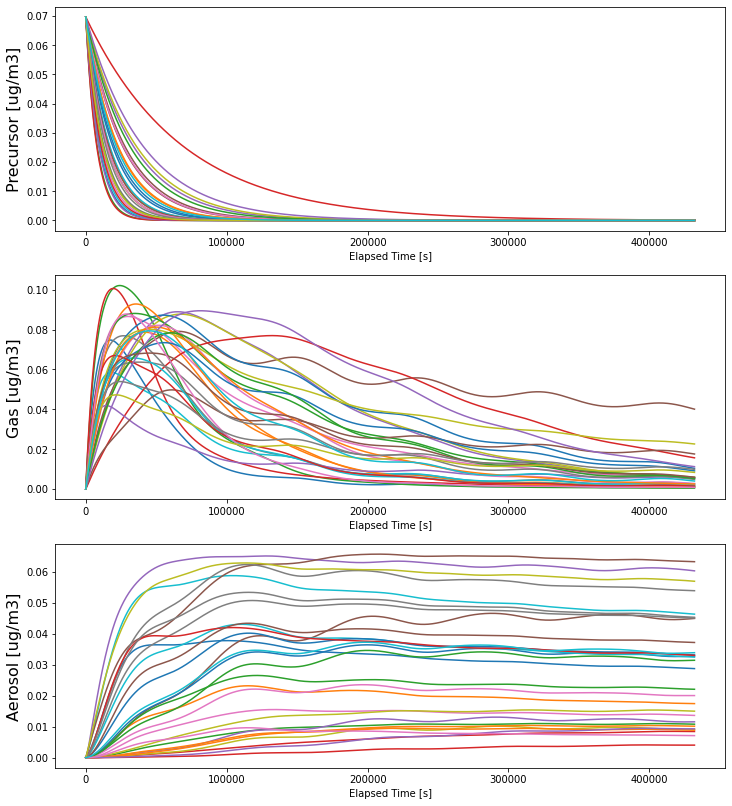

In [6]:
# Spaghetti plot random experiment timeseries
num_expiriments = 30
exps = sorted(random.sample(list(train['id'].unique()), num_expiriments))
plot_df = train.loc[train['id'].isin(exps)].reset_index(drop=True)

fig, ax = plt.subplots(3,1, figsize=(12,14))
for i,lab in enumerate(['Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug/m3]']):
    for exp in exps:
        ax[i].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,i+1])
    ax[i].set_xlabel('Elapsed Time [s]')
    ax[i].set_ylabel(lab, fontsize=16) 

## Data Preperation
Here we prepare the data for machine learning by taking the respective variables from each column, offsetting the output data by 1 timestep (this is done inside the `prepare_data()` function, and scale. Make sure to not re-fit the scaler on the validation/test data and only `transform()` it. 

In [7]:
input_vars, output_vars = train.columns, train.columns[[0,1,2,3,-1]]
train_in, train_out = prepare_data(train, input_vars, output_vars)
val_in, val_out = prepare_data(val, input_vars, output_vars)

input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

scaled_train_in = input_scaler.fit_transform(train_in.iloc[:,1:-1])
scaled_train_out = output_scaler.fit_transform(train_out.iloc[:,1:-1])
scaled_val_in = input_scaler.transform(val_in.iloc[:,1:-1])
scaled_val_out = output_scaler.transform(val_out.iloc[:,1:-1])

In [8]:
scaled_train_in.shape, scaled_train_out.shape, scaled_val_in.shape, scaled_val_out.shape,

((2015999, 9), (2015999, 3), (287999, 9), (287999, 3))

## Baseline Machine Learning Model
Here we use a pretty basic Dense Neural Network to predict the 3 output variables at the next timestep. We will then feed this into the Box Emulator model to run forward in time for n timesteps.

In [9]:
%%time
tf.random.set_seed(seed)
mod = dense_neural_net()
history = mod.fit(scaled_train_in, scaled_train_out, validation_data=(scaled_val_in, scaled_val_out), 
                  batch_size=256, epochs=5, verbose=1)
mod.summary()

Epoch 1/5
7875/7875 [==============================] - 23s 3ms/step - loss: 5.6081e-04 - val_loss: 3.2177e-04
Epoch 2/5
7875/7875 [==============================] - 23s 3ms/step - loss: 2.8966e-04 - val_loss: 2.8715e-04
Epoch 3/5
7875/7875 [==============================] - 23s 3ms/step - loss: 2.8602e-04 - val_loss: 2.8057e-04
Epoch 4/5
7875/7875 [==============================] - 23s 3ms/step - loss: 2.8473e-04 - val_loss: 2.9204e-04
Epoch 5/5
7875/7875 [==============================] - 23s 3ms/step - loss: 2.8392e-04 - val_loss: 2.7620e-04
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               1000      
_________________________________________________________________
dense_1 (Dense)              (None, 100

## Box Emulator Model
This model (`box_emulator()`), takes one timestep of initial conditions to feed the neural network we built. It then predicts one timestep, and uses the prediction as the input for another prediction (along with the static environmental variables), and so forth for *n* timesteps. In actual practice, the environmental variables from the climate model would be varying as well, but we use a variety of experiments with variable enviromental factors to learn from and simplify the process. 

The `run_emulator_ensemble()` function takes *n* random experiments and runs the `box_emulator()` for the length of each experiment and returns the predictions as well as the corresponding truth values.\

We can then use the `evaluate_box_mod()` to return a variety of performance metrics.

NOTE: It takes ~40 seconds per experiment to run the box emulator.

In [10]:
%%time
random.seed(seed)
num_exps = 5
pred_box, true_box = run_emulator_ensemble(val_in, mod, num_exps, input_vars, input_scaler, output_scaler)

CPU times: user 3min 25s, sys: 4.86 s, total: 3min 30s
Wall time: 3min 26s


## Evaluation

In [11]:
# get predictions and truth
pred_nn = pd.DataFrame(output_scaler.inverse_transform(mod.predict(scaled_val_in))).iloc[1:,:]
true_val = val_out.iloc[:-1,1:4]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn)

Metrics for base model:
RMSE: Precursor: 0.00024, Gas: 0.00020, Aerosols: 0.00022
R2: Precursor: 0.99972, Gas: 0.99993, Aerosols: 0.99993
Hellenger Distance: Precursor: 0.00003, Gas: 0.00003, Aerosols: 0.00503


Metrics for Box Emulator:
RMSE: Precursor: 0.00399, Gas: 0.06887, Aerosols: 0.04944
R2: Precursor: 0.91119, Gas: 0.00214, Aerosols: 0.87568
Hellenger Distance: Precursor: 0.52671, Gas: 0.64258, Aerosols: 0.86695


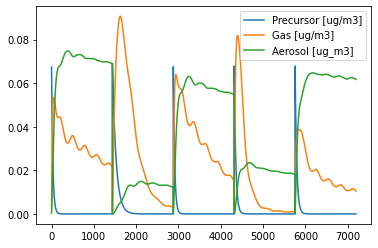

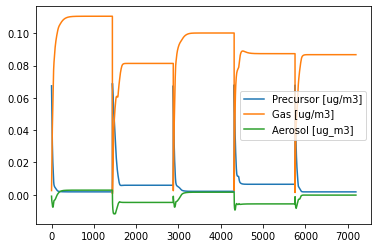

In [12]:
print('Metrics for Box Emulator:')
evaluate_mod(true_box, pred_box)

## Quick plot to see if emulator is capturing the patterns
true_box.iloc[:,0:3].plot()
pred_box.iloc[:,0:3].plot()

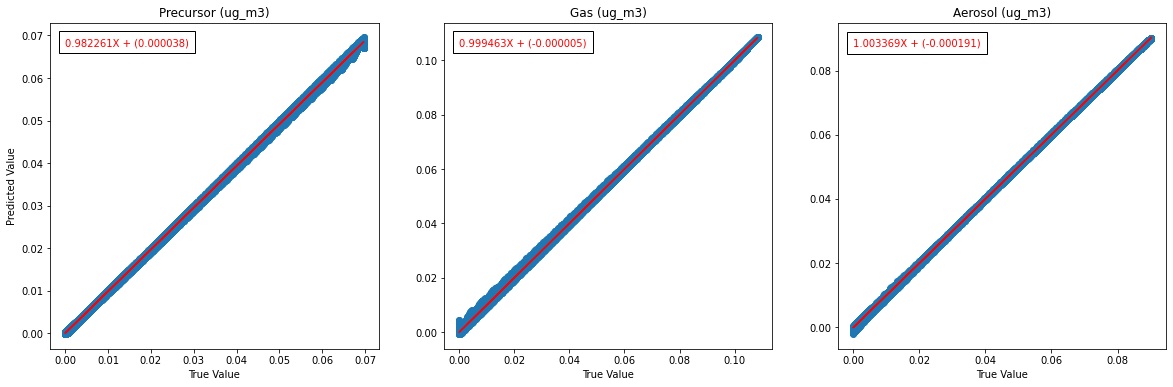

In [61]:
from scipy import stats

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
#fig.subplots_adjust(hspace=0.5)

for i in range(3):

  slope, intercept, r_value, p_value, std_err = stats.linregress(true_val.iloc[:,i], pred_nn.iloc[:,i])
  ax[i].scatter(true_val.iloc[:,i], pred_nn.iloc[:,i])
  m = slope.astype(float)
  ax[i].plot(true_val.iloc[:,i], m*(true_val.iloc[:,i]) + intercept, 'red', linewidth=1.5)
  if i == 0:
    title_name = 'Precursor (ug_m3)'
    ax[i].set_xlabel('True Value')
    ax[i].set_ylabel('Predicted Value')
  elif i == 1:
    title_name = 'Gas (ug_m3)'
    ax[i].set_xlabel('True Value')
  else:
    title_name = 'Aerosol (ug_m3)'
    ax[i].set_xlabel('True Value')
  ax[i].set_title(title_name)
  ax[i].text(min(true_val.iloc[:,i]), max(pred_nn.iloc[:,i]), f"{'%.6f'%slope}X + ({'%.6f'%intercept})",verticalalignment='top', \
             horizontalalignment='left',color='red', bbox=dict(facecolor='none', edgecolor='black', pad=6.0))

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(RH_RS41, RH_RS92,s = 12, )

m = slope.astype(float)

# Add a regression line
ax.plot(RH_RS41, m*RH_RS41 + intercept, 'red', linewidth=2.2)
ax.set_xlim(0, 86)
ax.set_ylim(0, 86)
ax.set_xlabel('RH from RS41 (%)',fontsize=20)
ax.set_ylabel('RH from RS92 (%)',fontsize=20)
ax.text(2, 84, f"{'%.6f'%slope}X + {'%.6f'%intercept}",verticalalignment='top', horizontalalignment='left',color='red', fontsize=20,\
        bbox=dict(facecolor='none', edgecolor='black', pad=6.0))

plt.show()

As you can see, it is relatively easy to train the base network to predict t+1 values. It is far more challenging to model the length of the experiment (~1440 timesteps). Furthermore, you may discover that better performance on the neural network may not mean better performance with the box emulator. 

Some potential ideas for better emulator performance: adding some noise to the training data to prevent overfitting, or using a recurrent neural network/LSTM to utilize more than one timestep to inform prediction of the next. 

| Model Type | Metric | Variable |||
| ------------- | :----:|:-------:|:------:|:-----|
|  Baseline DNN|| Precursor | Gas | Aerosols |   
|              | RMSE: |**0.00019**|**0.00035**|**0.00014**|
|              | R2: |**0.99979**|**0.99984**|**0.99997**|
|              | Hellenger Distance: |**0.00002**|**0.00011**|**0.00004**|
|||||
|  Box Emulator|| Precursor | Gas | Aerosol |   
|              | RMSE: |**0.007**|**0.048**|**0.021**|
|              | R2: |**0.685**|**0.031**|**0.410**|
|              | Hellenger Distance: |**0.067**|**0.256**|**0.329**|

## Hackathon Challenges

### Monday
* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

## Monday's code goes here




### 1. Load the data

In [3]:
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test1, train1, val1 = map(fetch_data, gecko_files)

print('Shape of train dataset:', train1.shape)
print('Shape of test dataset:', test1.shape)
print('Shape of val dataset:', val1.shape)

Shape of train dataset: (2016000, 11)
Shape of test dataset: (288000, 11)
Shape of val dataset: (288000, 11)


### 2. Exploring data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


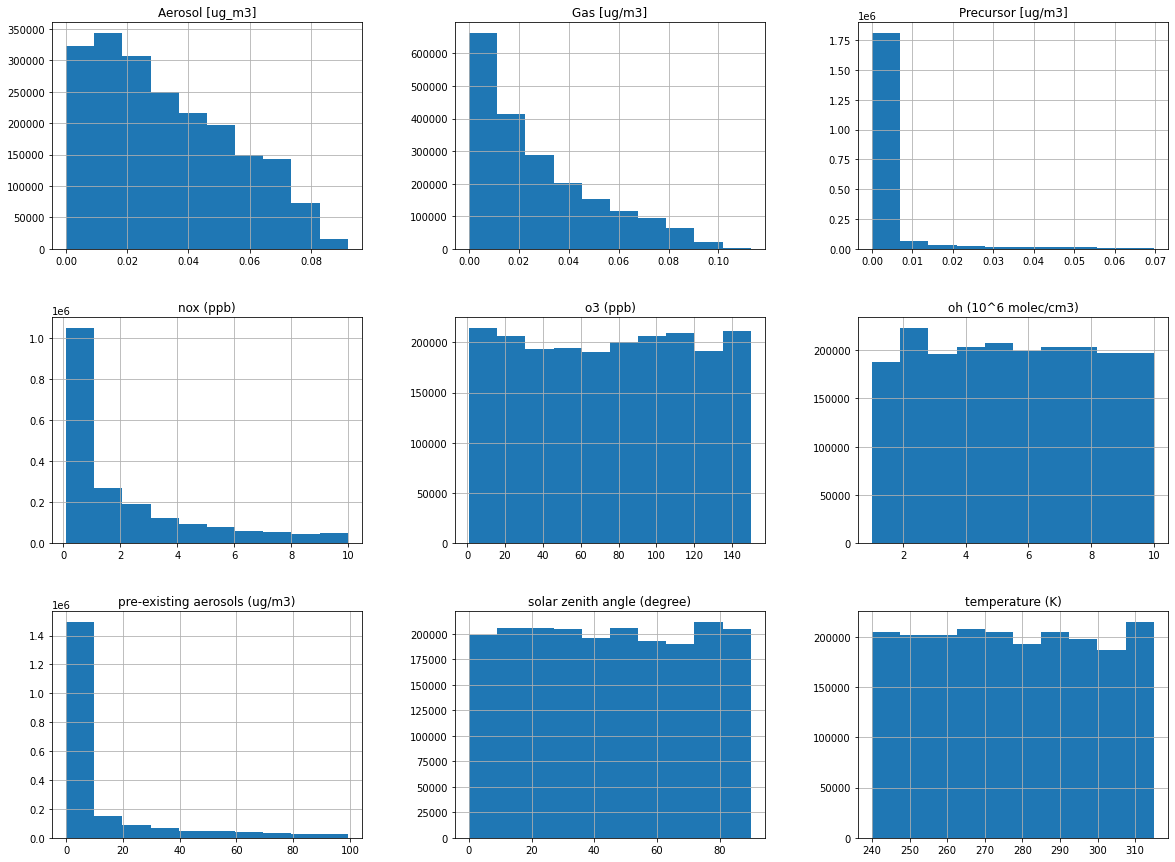

In [4]:
# Visualization of train data and saving image to Google Drive
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

hist = train1.iloc[:,1:-1].hist(figsize=(20,15))

images_dir = '/content/gdrive/My Drive/Colab Notebooks/Image_Output'
plt.savefig(f"{images_dir}/train_hist.png", bbox_inches = 'tight')
#plt.savefig('hist.png', bbox_inches = 'tight')

In [5]:
# Get some summary statistics of the training data
train1.groupby('id').mean().describe()

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3)
count,1.400000e+03,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000
mean,2.160005e+05,0.003125,0.027601,0.032703,277.413314,44.923263,11.388653,75.422052,2.124920,5.493831
std,2.329138e-10,0.002215,0.013710,0.020581,21.712817,26.064725,21.082846,43.495636,2.468413,2.582480
min,2.160005e+05,0.001244,0.004393,0.001704,240.024774,0.018612,0.010031,1.017131,0.100186,1.011878
25%,2.160005e+05,0.001598,0.016943,0.015331,258.824046,22.235231,0.099235,36.417272,0.314910,3.231017
50%,2.160005e+05,0.002253,0.024975,0.028837,277.096217,44.858750,1.085966,76.044879,1.004467,5.479992
75%,2.160005e+05,0.003803,0.035183,0.048352,296.098148,68.039551,10.946353,112.534705,3.059370,7.758317
max,2.160005e+05,0.012054,0.079415,0.086156,314.980647,89.966654,99.280288,149.927193,9.980638,9.999925


### 3. Data Preperation (transformation and scaling) 
#### Test two different transformation and scaling methods

In [6]:
input_vars1, output_vars1 = train1.columns, train1.columns[[0,1,2,3,-1]]
train_in1, train_out1 = prepare_data(train1, input_vars1, output_vars1)
val_in1, val_out1 = prepare_data(val1, input_vars1, output_vars1)

#### 3.1. Normalizing the data by Standardization

StandardScaler removes the mean and scales the data to unit variance [StandardScaler](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

In [7]:
input_scaler_s = StandardScaler()
output_scaler_s = StandardScaler()

In [8]:
scaled_train_in_s = input_scaler_s.fit_transform(train_in1.iloc[:,1:-1])
scaled_train_out_s = output_scaler_s.fit_transform(train_out1.iloc[:,1:-1])
scaled_val_in_s = input_scaler_s.transform(val_in1.iloc[:,1:-1])
scaled_val_out_s = output_scaler_s.transform(val_out1.iloc[:,1:-1])

In [9]:
scaled_train_in_s.mean(axis=0)

array([ 6.26941491e-17,  5.35332185e-16,  1.37044588e-15, -2.22478936e-15,
        1.07638819e-16, -3.97283814e-17, -6.61763741e-16,  3.01586066e-16,
        1.73251270e-16])

In [10]:
scaled_train_in_s.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### 3.2. Scaling by PowerTransformer
PowerTransformer applies a power transformation to each feature to make the data more Gaussian-like. Currently, PowerTransformer implements the Yeo-Johnson and Box-Cox transforms. The power transform finds the optimal scaling factor to stabilize variance and mimimize skewness through maximum likelihood estimation. By default, PowerTransformer also applies zero-mean, unit variance normalization to the transformed output. Note that Box-Cox can only be applied to strictly positive data. Income and number of households happen to be strictly positive, but if negative values are present the Yeo-Johnson transformed is to be preferred ([Source](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)).

In [11]:
input_scaler_p = PowerTransformer()
output_scaler_p = PowerTransformer()

In [12]:
scaled_train_in_p = input_scaler_s.fit_transform(train_in1.iloc[:,1:-1])
scaled_train_out_p = output_scaler_s.fit_transform(train_out1.iloc[:,1:-1])
scaled_val_in_p = input_scaler_s.transform(val_in1.iloc[:,1:-1])
scaled_val_out_p = output_scaler_s.transform(val_out1.iloc[:,1:-1])

In [13]:
scaled_train_in_p.mean(axis=0)

array([ 6.26941491e-17,  5.35332185e-16,  1.37044588e-15, -2.22478936e-15,
        1.07638819e-16, -3.97283814e-17, -6.61763741e-16,  3.01586066e-16,
        1.73251270e-16])

In [14]:
scaled_train_in_p.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

### 4. Test one dimensionality reduction method (PCA)

In [15]:
from sklearn.decomposition import PCA

#Perform Principal component analysis. I am going to reduce down to 5 dimensions from 9 dimensions. Before applying PCA it advisable to scale the dataset
pca = PCA(n_components=5)

pca_train_in = input_scaler_s.fit_transform(pca.fit_transform(train_in1.iloc[:,1:-1]))
pca_df_train_in = pd.DataFrame(data = pca_train_in, columns = ['pc_1', 'pc_2','pc_3','pc_4','pc_5'])

pca_val_in = input_scaler_s.fit_transform(pca.fit_transform(val_in1.iloc[:,1:-1]))
pca_df_val_in = pd.DataFrame(data = pca_val_in, columns = ['pc_1', 'pc_2','pc_3','pc_4','pc_5'])

### 5. Train a linear model

In [54]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

In [55]:
modlinear = linear_model.LinearRegression() # linear regression model (logistic regression model, logistic_mod = linear_model.LogisticRegression())
modlinear.fit(pca_train_in,scaled_train_out_s) # Training the model using the training dataset
predlinear = modlinear.predict(pca_val_in) # predictions

In [56]:
print('Mean squared error for Precursor: %.4f' % mean_squared_error(scaled_val_out_s[:,0], predlinear[:,0], squared=False))
print('Mean squared error for Gas: %.4f' % mean_squared_error(scaled_val_out_s[:,1], predlinear[:,1], squared=False))
print('Mean squared error for Aerosols: %.4f' % mean_squared_error(scaled_val_out_s[:,2], predlinear[:,2], squared=False))

Mean squared error for Precursor: 0.9793
Mean squared error for Gas: 0.9911
Mean squared error for Aerosols: 1.2552


### 6. Train a decision tree ensemble method of your choice

In [65]:
from sklearn.ensemble import RandomForestRegressor

rf_mod = RandomForestRegressor()
rf_mod.fit(pca_train_in, scaled_train_out_s)
predsrandom = rf_mod.predict(pca_val_in)

In [32]:
print('Mean squared error for Precursor: %.4f' % mean_squared_error(scaled_val_out_s[:,0], predlinear[:,0], squared=False))
print('Mean squared error for Gas: %.4f' % mean_squared_error(scaled_val_out_s[:,1], predlinear[:,1], squared=False))
print('Mean squared error for Aerosols: %.4f' % mean_squared_error(scaled_val_out_s[:,2], predlinear[:,2], squared=False))

Mean squared error for Precursor: 0.9793
Mean squared error for Gas: 0.9911
Mean squared error for Aerosols: 1.2552


### Tuesday
* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

In [16]:
def dense_neural_net_w_noise(num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001,
                     num_input_columns=9, num_output_columns=3, stddev = 0.1):
    """ Build and return dense neural network with specified hyperparameters"""
    input_layer = Input(num_input_columns)
    n_net = input_layer
    for l in range(num_layers):
        n_net= Dense(num_neurons, activation=activation)(n_net)
        gaus = GaussianNoise(stddev)(n_net, training=True)
    out = Dense(num_output_columns)(gaus)
    mod = Model(input_layer, out)
    mod.compile(Adam(learning_rate=learning_rate), "mse")
    return mod

In [18]:
%%time
tf.random.set_seed(seed)
mod1 = dense_neural_net_w_noise()
history = mod1.fit(scaled_train_in, scaled_train_out, validation_data=(scaled_val_in, scaled_val_out), 
                  batch_size=256, epochs=5, verbose=1)
mod1.summary()

In [68]:
%%time
random.seed(seed)
num_exps = 5
pred_box, true_box = run_emulator_ensemble(val_in, mod1, num_exps, input_vars, input_scaler, output_scaler)

CPU times: user 3min 33s, sys: 5.35 s, total: 3min 38s
Wall time: 3min 34s


In [36]:
## Evaluation

In [76]:
# get predictions and truth
pred_nn1 = pd.DataFrame(output_scaler.inverse_transform(mod1.predict(scaled_val_in))).iloc[1:,:]
true_val1 = val_out.iloc[:-1,1:4]

print('Metrics for base model:')
evaluate_mod(true_val1, pred_nn1)

Metrics for base model:
RMSE: Precursor: 0.00036, Gas: 0.00062, Aerosols: 0.00047
R2: Precursor: 0.99873, Gas: 0.99945, Aerosols: 0.99955
Hellenger Distance: Precursor: 0.04293, Gas: 0.00031, Aerosols: 0.00201


Metrics for Box Emulator:
RMSE: Precursor: 0.03783, Gas: 0.07564, Aerosols: 0.04650
R2: Precursor: 0.08745, Gas: 0.19088, Aerosols: 0.02388
Hellenger Distance: Precursor: 0.40488, Gas: 0.61071, Aerosols: 0.48409


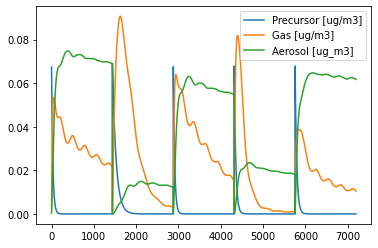

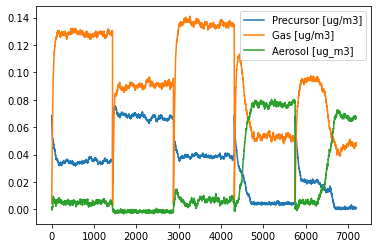

In [77]:
print('Metrics for Box Emulator:')
evaluate_mod(true_box, pred_box)

## Quick plot to see if emulator is capturing the patterns
true_box.iloc[:,0:3].plot()
pred_box.iloc[:,0:3].plot()

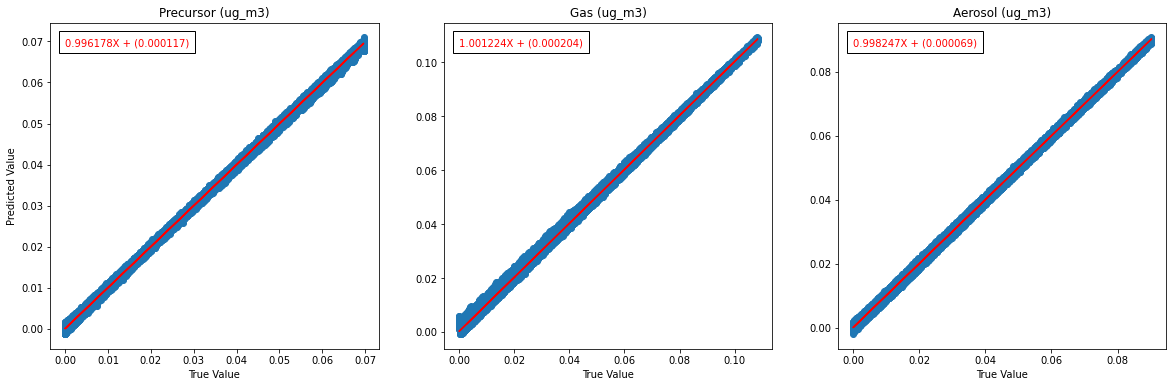

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
#fig.subplots_adjust(hspace=0.5)

for i in range(3):

  slope, intercept, r_value, p_value, std_err = stats.linregress(true_val1.iloc[:,i], pred_nn1.iloc[:,i])
  ax[i].scatter(true_val1.iloc[:,i], pred_nn1.iloc[:,i])
  m = slope.astype(float)
  ax[i].plot(true_val1.iloc[:,i], m*(true_val1.iloc[:,i]) + intercept, 'red', linewidth=1.5)
  if i == 0:
    title_name = 'Precursor (ug_m3)'
    ax[i].set_xlabel('True Value')
    ax[i].set_ylabel('Predicted Value')
  elif i == 1:
    title_name = 'Gas (ug_m3)'
    ax[i].set_xlabel('True Value')
  else:
    title_name = 'Aerosol (ug_m3)'
    ax[i].set_xlabel('True Value')
  ax[i].set_title(title_name)
  ax[i].text(min(true_val1.iloc[:,i]), max(pred_nn1.iloc[:,i]), f"{'%.6f'%slope}X + ({'%.6f'%intercept})",verticalalignment='top', \
             horizontalalignment='left',color='red', bbox=dict(facecolor='none', edgecolor='black', pad=6.0))

plt.show()

### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

### 1. Calculate three relevant evaluation metrics for each ML solution and baseline

In [79]:
### Baseline Machine Learning Model
print('Metrics for base model:')
evaluate_mod(true_val, pred_nn)

Metrics for base model:
RMSE: Precursor: 0.00024, Gas: 0.00020, Aerosols: 0.00022
R2: Precursor: 0.99972, Gas: 0.99993, Aerosols: 0.99993
Hellenger Distance: Precursor: 0.00003, Gas: 0.00003, Aerosols: 0.00503


In [80]:
### Dense neural network with noise 
print('Metrics for base model with noise:')
evaluate_mod(true_val, pred_nn)

Metrics for base model with noise:
RMSE: Precursor: 0.00024, Gas: 0.00020, Aerosols: 0.00022
R2: Precursor: 0.99972, Gas: 0.99993, Aerosols: 0.99993
Hellenger Distance: Precursor: 0.00003, Gas: 0.00003, Aerosols: 0.00503


In [ ]:
### Linear Model scaled by Standardization
def evaluate_mod_linear(true_output, model_results):
    
    print('RMSE: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        rmse(true_output, model_results),
        rmse(true_output, model_results),
        rmse(true_output, model_results)))
    print('R2: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        r2_corr(true_output, model_results),
        r2_corr(true_output, model_results),
        r2_corr(true_output, model_results)))
    print('Hellenger Distance: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        hellinger_distance(true_output, model_results),
        hellinger_distance(true_output, model_results),
        hellinger_distance(true_output, model_results)))
    
    return

print('Metrics for linear model:')
evaluate_mod_linear(scaled_val_out_s, predlinear)

### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them 

In [ ]:
#Thursday's code goes here


## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.